# Imports

## Common

In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import random_split, Dataset, DataLoader, ConcatDataset, Subset, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
!pip install prv-accountant

from IPython.display import clear_output

## TF

In [ ]:
"""
Adapted from https://colab.research.google.com/github/google-research/simclr/blob/master/colabs/finetuning.ipynb
"""

import numpy as np

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import tensorflow_hub as hub
from sklearn.linear_model import LogisticRegression
import os


## HuggingFace

In [2]:
!pip install datasets
!pip install transformers
!pip install timm

import transformers
import datasets


## Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Utilities

## Analytical Gaussian Mechanism

In [3]:
#Analytical Gaussian Mechanism (taken from https://github.com/BorjaBalle/analytic-gaussian-mechanism/blob/master/agm-example.py)
from math import exp, sqrt
from scipy.special import erf

def cagm(epsilon, delta, GS, tol = 1.e-12):
    """ Calibrate a Gaussian perturbation for differential privacy using the analytic Gaussian mechanism of [Balle and Wang, ICML'18]

    Arguments:
    epsilon : target epsilon (epsilon > 0)
    delta : target delta (0 < delta < 1)
    GS : upper bound on L2 global sensitivity (GS >= 0)
    tol : error tolerance for binary search (tol > 0)

    Output:
    sigma : standard deviation of Gaussian noise needed to achieve (epsilon,delta)-DP under global sensitivity GS
    """

    def Phi(t):
        return 0.5*(1.0 + erf(float(t)/sqrt(2.0)))

    def caseA(epsilon,s):
        return Phi(sqrt(epsilon*s)) - exp(epsilon)*Phi(-sqrt(epsilon*(s+2.0)))

    def caseB(epsilon,s):
        return Phi(-sqrt(epsilon*s)) - exp(epsilon)*Phi(-sqrt(epsilon*(s+2.0)))

    def doubling_trick(predicate_stop, s_inf, s_sup):
        while(not predicate_stop(s_sup)):
            s_inf = s_sup
            s_sup = 2.0*s_inf
        return s_inf, s_sup

    def binary_search(predicate_stop, predicate_left, s_inf, s_sup):
        s_mid = s_inf + (s_sup-s_inf)/2.0
        while(not predicate_stop(s_mid)):
            if (predicate_left(s_mid)):
                s_sup = s_mid
            else:
                s_inf = s_mid
            s_mid = s_inf + (s_sup-s_inf)/2.0
        return s_mid

    delta_thr = caseA(epsilon, 0.0)

    if (delta == delta_thr):
        alpha = 1.0

    else:
        if (delta > delta_thr):
            predicate_stop_DT = lambda s : caseA(epsilon, s) >= delta
            function_s_to_delta = lambda s : caseA(epsilon, s)
            predicate_left_BS = lambda s : function_s_to_delta(s) > delta
            function_s_to_alpha = lambda s : sqrt(1.0 + s/2.0) - sqrt(s/2.0)

        else:
            predicate_stop_DT = lambda s : caseB(epsilon, s) <= delta
            function_s_to_delta = lambda s : caseB(epsilon, s)
            predicate_left_BS = lambda s : function_s_to_delta(s) < delta
            function_s_to_alpha = lambda s : sqrt(1.0 + s/2.0) + sqrt(s/2.0)

        predicate_stop_BS = lambda s : abs(function_s_to_delta(s) - delta) <= tol

        s_inf, s_sup = doubling_trick(predicate_stop_DT, 0.0, 1.0)
        s_final = binary_search(predicate_stop_BS, predicate_left_BS, s_inf, s_sup)
        alpha = function_s_to_alpha(s_final)

    sigma = alpha*GS/sqrt(2.0*epsilon)

    return sigma



## DP Normalized Centroids Model

In [4]:
#Sum!
from sklearn.preprocessing import normalize

class DP_CentroidClassifier():
  def __init__(self, epsilon = 1, delta=0.01):

    self.centroids = None
    self.centroids_labels = None
    self.classes = None
    self.epsilon = epsilon
    self.delta = delta
    self.vars = None
    self.prediction_model_type = None
    self.prediction_model_object = None


  def dp_fit(self, X_train, y_train, amplification_args = None, normalization = True, debug = False,
             prediction_model_for_representers = 'cosine_knn'):

    self.classes = np.unique(y_train)
    self.prediction_model_type = prediction_model_for_representers

    centroids_labels = []
    centroids = []
    sigmas = []
    representers_count = 1

    # calculate noise
    sigma = 0

    # possible privacy amplification
    if amplification_args != None:
      sigma = self.numerical_composition_sigma(**amplification_args)
      representers_count = amplification_args['representers_count']

    else:
      sigma = cagm(self.epsilon, self.delta, 1)



    X_train_clipped = normalize(X_train)

    #no feature normalization
    if debug:
      X_train_clipped = X_train



    for representer in range(representers_count):

      if amplification_args != None:
        sampling_prob = amplification_args['sampling_probability']
        X, y = self.privacy_amplification(sampling_prob, X_train_clipped, y_train)

      else:
        X = X_train_clipped
        y = y_train

      for c in self.classes:
        #calculate sum
        class_centroid = 0
        class_centroid += np.sum(X[y == c], axis=0)

        #perturb class mean
        noisy_class_centroid = self.perturb_features(class_centroid, sigma)
        centroids.append(noisy_class_centroid)
        centroids_labels.append(c)



    self.centroids_labels = np.array(centroids_labels)

    centroids = np.array(centroids)

    if normalization:
      self.centroids = normalize(centroids)

    else:
      self.centroids = centroids


    match self.prediction_model_type:
      case 'cosine_knn':
        pass

      case 'l2_knn':
        pass

      case 'logistic_regression':
        from sklearn.linear_model import LogisticRegression as LR
        lr = LR()
        lr.fit(self.centroids, self.centroids_labels)
        self.prediction_model_object = lr

      case other:
        print('prediction model type is non-default!')


  def predict_proba(self, X_test):
    n_samples = X_test.shape[0]
    y_test_probs = np.zeros((n_samples, len(self.classes)))


    for i in range(n_samples):
      #calculate distance from centroids
      dists = np.linalg.norm(X_test[i,:] - self.centroids, axis = 1)

      #use softmax to transform dists to probabilities
      from scipy.special import softmax
      y_test_probs[i,:] = 1 - softmax(dists)

    return y_test_probs



  def predict(self, X_test):

    n_samples = X_test.shape[0]
    y_test = np.zeros(n_samples)

    match self.prediction_model_type:
      case 'cosine_knn':
        for i in range(n_samples):
          dists = dists = -X_test[i,:]@(self.centroids.T)
          y_test[i] = self.centroids_labels[np.argmin(dists)]

      case 'l2_knn':
        for i in range(n_samples):
          dists = np.linalg.norm(X_test[i,:] - self.centroids, axis = 1)
          y_test[i] = self.centroids_labels[np.argmin(dists)]

      case 'logistic_regression':
        lr = self.prediction_model_object
        y_test = lr.predict(normalize(X_test))

      case other:
        print('prediction model type is non-default (should have been warned before!)')



    return y_test


  def score(self, X_test, y_test):

    predictions = self.predict(X_test)
    predictions = predictions.reshape(y_test.shape[0])
    return (np.sum(predictions == y_test.reshape(y_test.shape[0]))/y_test.shape[0])


  def calculate_entropy(self, X):

    from scipy.stats import entropy
    centroids = self.centroids
    classes = self.classes


    probs = self.predict_proba(X)
    ents = entropy(probs, axis=1)

    return ents


  def perturb_features(self, X_train, sigma, private_labels = False):

    #add noise
    X_noisy = X_train + sigma*np.random.standard_normal(X_train.shape)

    return X_noisy




  def privacy_amplification(self, q, X, y):
    X_sampled = []
    y_sampled = []

    for c in self.classes:
        X_class_sampled, y_class_sampled = self.per_class_privacy_amplification(q,
                                                     X[y == c], y[y == c])
        X_sampled.append(X_class_sampled)
        y_sampled.append(y_class_sampled)

    X_sampled = np.concatenate(X_sampled)
    y_sampled = np.concatenate(y_sampled)

    return X_sampled, y_sampled


  def per_class_privacy_amplification(self, q, X, y):
    n_samples = X.shape[0]
    sampled_indices = np.random.binomial(1, q, n_samples)
    return X[sampled_indices == 1], y[sampled_indices == 1]



  def numerical_composition_sigma(self, sampling_probability = 0.1, representers_count = 10):
    from prv_accountant.dpsgd import find_noise_multiplier

    return find_noise_multiplier(sampling_probability, num_steps = representers_count,
                                 target_epsilon = self.epsilon, target_delta = self.delta, eps_error=self.epsilon/10)


## Deep Models

In [5]:
class ModelExperiment():
  def __init__(self, model_name = 'dino_vitb16'):
    self.model_name = model_name
    self.models = dict()

    self.download()

  def download(self):
    models = dict()

    match self.model_name:

      # Vision Models
      case 'resnet50':
        models['model'] = torchvision.models.resnet50(weights = 'DEFAULT')

      case 'resnet152':
        models['model'] = torchvision.models.resnet152(weights = 'DEFAULT')

      case 'dino_vitb16':
        models['model'] = transformers.ViTModel.from_pretrained('facebook/dino-vitb16')

      case 'msn_vitb16':
        models['model'] = transformers.ViTMSNModel.from_pretrained('facebook/vit-msn-base')


      # NLP Models
      case 'data2vec':
        hf_path = 'facebook/data2vec-text-base'
        models['autotokenizer'] = transformers.AutoTokenizer.from_pretrained(hf_path)
        models['model'] = transformers.AutoModel.from_pretrained(hf_path)

      case 'unsup_simcse_roberta_base':
        hf_path = 'princeton-nlp/unsup-simcse-roberta-base'
        models['autotokenizer'] = transformers.AutoTokenizer.from_pretrained(hf_path)
        models['model'] = transformers.AutoModel.from_pretrained(hf_path)

      case 'unsup_simcse_roberta_large':
        hf_path = 'princeton-nlp/unsup-simcse-roberta-large'
        models['autotokenizer'] = transformers.AutoTokenizer.from_pretrained(hf_path)
        models['model'] = transformers.AutoModel.from_pretrained(hf_path)

      case 'sup_simcse_roberta_base':
        hf_path = 'princeton-nlp/sup-simcse-roberta-base'
        models['autotokenizer'] = transformers.AutoTokenizer.from_pretrained(hf_path)
        models['model'] = transformers.AutoModel.from_pretrained(hf_path)

      case 'sup_simcse_roberta_large':
        hf_path = 'princeton-nlp/sup-simcse-roberta-large'
        models['autotokenizer'] = transformers.AutoTokenizer.from_pretrained(hf_path)
        models['model'] = transformers.AutoModel.from_pretrained(hf_path)

      case 'sup_simcse_bert_base':
        hf_path = 'princeton-nlp/sup-simcse-bert-large-uncased'
        models['autotokenizer'] = transformers.AutoTokenizer.from_pretrained(hf_path)
        models['model'] = transformers.AutoModel.from_pretrained(hf_path)

      case 'sup_simcse_bert_large':
        hf_path = 'princeton-nlp/sup-simcse-bert-large-uncased'
        models['autotokenizer'] = transformers.AutoTokenizer.from_pretrained(hf_path)
        models['model'] = transformers.AutoModel.from_pretrained(hf_path)

      case other:
        print('Model identifier not found!, possible models: ')
        print(self.get_default_models())

    self.models = models

  def get_model(self):
    return self.models


  def get_default_models(self):
    default_models = dict()
    vision_models = ['dino', 'msn', 'resnet (152, 50)', 'simclrv2']
    nlp_models = ['data2vec', 'simcse sup roberta large, base', 'simcse unsup roberta large, base', 'simcse sup bert large, base']
    default_models['vision'] = vision_models
    default_models['nlp'] = nlp_models
    return default_models



## Datasets

In [6]:
from torchvision import datasets, transforms

class DatasetExperiment():
  def __init__(self, name = 'cifar10_torch', task_name = None, preprocessing_args = {'type' : None}):
    self.name = name
    self.task_name = task_name
    self.class_descriptions = None

    self.transform = self.create_transform(preprocessing_args)
    self.download()


  def download(self):
    # pytorch
    match self.name:
      case 'cifar10_torch':
        self.train_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=self.transform)
        self.test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                              download=True, transform=self.transform)

        self.classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

      # simclrv2
      case 'cifar10_tf':
        (xtrain, ytrain), (xtest, ytest) = tf.keras.datasets.cifar10.load_data()
        xtrain = xtrain.astype(np.float32) / 255.0
        xtest = xtest.astype(np.float32) / 255.0
        y_train = ytrain.reshape(-1)
        y_test = ytest.reshape(-1)

      case 'mnist_torch':
        self.train_data = torchvision.datasets.MNIST(root='./data', train=True,
                                          download=True, transform=self.transform)
        self.test_data = torchvision.datasets.MNIST(root='./data', train=False,
                                              download=True, transform=self.transform)




      # huggingface nlp data
      case 'glue':
        task = self.task_name
        dataset = datasets.load_dataset('glue', task)
        train_dataset = dataset['train']
        test_dataset = dataset['validation']
        train_dataset.set_format(type = 'torch')
        test_dataset.set_format(type = 'torch')


      case other:
        print('Dataset identifier not found!')


  # preprocess data
  # -- preprocessing arguments --
  # type : 'imagenet' (normal without resize), 'imagenet_resize' (normal with resize for transformers)
  # size : 224 for vit-b/16 transformers
  def create_transform(self, preprocessing_args):
    transform = None

    preprocessing_type = preprocessing_args['type']

    grayscale_transform = None
    if self.name in ['mnist_torch', 'fashion_mnist_torch']:
      grayscale_transform = transforms.Grayscale(3)

    resize_transform = None
    if preprocessing_type.endswith('resize'):
      size = preprocessing_args['resize_size']
      resize_transform = transforms.Resize(size)

    match preprocessing_type:

      # imagenet pretrained
      case 'imagenet' | 'imagenet_resize':
        transform = transforms.Compose(
        [   grayscale_transform,
            resize_transform,
            transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.2, 0.2, 0.2))])


      ## TODO
      case 'imagenet_simclr':
        pass

      case None:
        pass

      case other:
        print('Preprocessing pipeline identifier not found!')

    return transform



  # return dataloaders for train and test data.
  # -- dataloader args --
  # batch_size
  def get_dataloaders(self, dataloader_args = dict()):
    train_dataloader = DataLoader(self.train_data, **dataloader_args)
    test_dataloader = DataLoader(self.test_data, **dataloader_args)

    return train_dataloader, test_dataloader




# stores features
def store_features(features, root, experiment_identifier = '_'):

  parent_path = root

  if not root.endswith('/'):
    parent_path += '/'

  for key in features.keys():
    path = parent_path + experiment_identifier + '_' + key
    np.save(path, features[key])


# loads features as a dictionary
def load_features(root, experiment_identifier, keys):
  features = dict()

  if root.endswith('/'):
    parent_path = root + experiment_identifier + '_'

  else:
    parent_path = root + '/' + experiment_identifier + '_'

  for key in keys:
    path = parent_path + key + ".npy"
    features[key] = np.load(path)

  return features



def get_dataloader_from_xy(X, y, dataloader_args):
    dataset = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
    dataloader = DataLoader(dataset, **dataloader_args)

    return dataloader


### SimCLR Preprocessin

In [7]:

# preprocessing functions for SimCLR


## Feature Extraction

In [8]:
from tqdm import tqdm

class ImageFeatureExtractor_Torch():
  def __init__(self, model, model_name):
    self.model = model
    self.model_name = model_name

    # a dict to store the activations
    self.activation = None
    self.hook = None
    self.hook_models = ['resnet50', 'resnet152']

  # extract features
  def extract(self, dataloader, device, verbose = True):

    # possibly register hook. the function checks model name to make sure a hook is needed
    self.register_hook()


    # initializations
    X, y = [], []
    self.model.eval()

    # feature extraction loop
    with torch.no_grad():
      # train features
      print("###Extracting features###")

      if verbose:
        dataloader_iterator = enumerate(tqdm(dataloader))

      else:
        dataloader_iterator = enumerate(dataloader)

      for i, (input, target) in dataloader_iterator:

        outputs = self.model(input.to(device))
        embeddings = self.get_embeddings(outputs)
        X.append(embeddings.cpu().numpy().squeeze())
        y.append(target.cpu().numpy())

    print("Done")


    # numpyify the features!
    X = np.concatenate(X)
    y = np.concatenate(y)

    if self.hook:
      self.hook.remove()

    return X, y


  # TODO
  def get_embeddings(self, outputs):

    match self.model_name:
      case 'dino_vitb16':
        ## DINO ViTb16
        embeddings = outputs.last_hidden_state[:,0]

      case 'msn_vitb16':
        embeddings = outputs.last_hidden_state[:,0]

      case 'resnet50':
        embeddings = self.activation['feats']

      case other:
        print("embeddings not found for model!")
        return

    return embeddings



  # torch method for restoring activations
  def getActivation(self, name):
    self.activation = dict()
    # the hook signature
    def hook(model, input, output):
      self.activation[name] = output.detach()
    return hook


  # register hook
  def register_hook(self):

    if self.model_name in self.hook_models:
      match self.model_name:
        case 'resnet50':
            final_embedding_layer = model.avgpool
        case other:
            print("error while registering hook!")

      # register forward hooks on the final embedding layer
      self.hook = final_embedding_layer.register_forward_hook(self.getActivation('feats'))

    else:
      return







  class SentenceClassificationFeatureExtractor_HF():
    def __init__(self, model, model_name, tokenizer):
      self.model = model
      self.model_name = model_name
      self.tokenizer = tokenizer
      self.embedding_type = None

      match model_name:
        case 'simcse_roberta':
          self.embedding_type = 'last_hidden_states'
        case other:
          print('model name not defined')
          return

    def extract(self, dataloader, device, dataset_name, task_name):
      # find correct keys to access text features using dataset and task name
      input_id, output_id, idx_id = None, None, None

      match dataset_name:
        case 'glue':

          match task_name:
            case 'sst2':
              input_id = 'sentence'
              output_id = 'label'
              idx_id = 'idx'

            case other:
              print('task identifier not found')
              return

        case other:
          print('dataset identifier not found')
          return


      X, y, idx = [], [], []
      dataloader_iterable = enumerate(tqdm(dataloader))

      self.model.eval()
      with torch.no_grad():
        print("Extracting embeddings!")

        for input, features in dataloader_iterable:
          idx.append((features[idx_id]).cpu().numpy())
          y.append(features[output_id].cpu().numpy())

          sentences = features[input_id]
          inputs = self.tokenizer(sentences, padding=True, truncation=True, return_tensors="pt").to(device)

          match self.embedding_type:
            case 'last_hidden_states':
              embeddings = self.model(**inputs, output_hidden_states=True, return_dict=True).last_hidden_state[:,0].to(device)

            case 'pooler_output':
              embeddings = model(**inputs, output_hidden_states=True, return_dict=True).pooler_output.to(device)

            case other:
              print('embedding type not defined')
              return

          X.append(embeddings.cpu().numpy())

      print('Done')
      return np.concatenate(X), np.concatenate(y), np.concatenate(idx)






## Evaluations

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm import tqdm

def accuracy_epsilon_sweep(dp_params = dict(), data = dict(), model_type = 'dp_normalized_centroids', dp_mechanism_args = dict()):
  delta = dp_params['delta']
  eps = dp_params['epsilons']
  accs = []

  # sweep epsilons
  for epsilon in tqdm(eps):

    # model
    if model_type == 'dp_normalized_centroids':
      X_train = data['X_train']
      X_test = data['X_test']
      y_train = data['y_train']
      y_test = data['y_test']

      dpc = DP_CentroidClassifier(epsilon = epsilon, delta = delta)
      dpc.dp_fit(X_train, y_train, **dp_mechanism_args)
      acc = dpc.score(X_test, y_test)

    # different privacy mechanisms?
    else:
      acc = 0

    accs.append(acc)

  return accs

def plot_epsilon_sweep(eps, accs, dataset_name = 'CIFAR-10', backbone_name = 'Dino ViT/16b'):
  plt.scatter(eps, accs)
  plt.title(f'{dataset_name} Accuracy With {backbone_name} Backbone')
  plt.xlabel('Epsilon')
  plt.ylabel('Accuracy')


def plot_dict(y_dict = dict(), x = [], title='', ylabel = 'Accuracy', xlabel = 'Epsilon'):

  keys = y_dict.keys()
  legends = []
  for key in keys:
    plt.scatter(x, y_dict[key])
    legends.append(key)

  plt.legend(legends)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)


def plot_hist_dict(data_dict = dict(), title = '', histogram_args = dict()):
  for key in data_dict.keys():
    plt.hist(data_dict[key], **histogram_args)

  plt.title(title)
  plt.legend(data_dict.keys())


def sample_dot_products(X, y, iterations):

  from tqdm import tqdm

  intra_class_dot_products = []
  inter_class_dot_products = []

  classes = np.unique(y)
  n_classes = len(classes)

  class_features = []
  features_per_class_count = []

  for i in range(n_classes):
    class_features.append(X[np.nonzero(y == classes[i])])
    features_per_class_count.append(class_features[i].shape[0])



  print('Sampling Intra Class Dot Products!')

  for i in tqdm(range(iterations)):

    #choose a class
    sampled_class = np.random.randint(n_classes)

    #sample embeddings
    emb1 =  class_features[sampled_class][np.random.randint(features_per_class_count[sampled_class]),:]
    emb2 =  class_features[sampled_class][np.random.randint(features_per_class_count[sampled_class]),:]

    #normalize embeddings
    emb1 /= np.linalg.norm(emb1)
    emb2 /= np.linalg.norm(emb2)

    intra_class_dot_products.append(np.dot(emb1, emb2))




  print('Sampling Inter Class Dot Products!')

  for i in tqdm(range(iterations)):

    #choose two different classes
    sampled_classes = np.random.choice(n_classes, size = 2, replace = False)

    #sample embeddings
    emb1 =  class_features[sampled_classes[0]][np.random.randint(features_per_class_count[sampled_class]),:]
    emb2 =  class_features[sampled_classes[1]][np.random.randint(features_per_class_count[sampled_class]),:]

    #normalize embeddings
    emb1 /= np.linalg.norm(emb1)
    emb2 /= np.linalg.norm(emb2)

    inter_class_dot_products.append(np.dot(emb1, emb2))

  dot_products = {'intra class': intra_class_dot_products, 'inter class': inter_class_dot_products}

  return dot_products


def sample_per_class_dot_products(X, y, iterations, class_names):
  from sklearn.preprocessing import normalize
  from tqdm import tqdm

  classes = np.unique(y)
  n_classes = len(classes)

  class_features = []
  features_per_class_count = []

  for i in range(n_classes):
    class_features.append(X[np.nonzero(y == classes[i])])
    features_per_class_count.append(class_features[i].shape[0])



  print('Sampling Per Class Dot Products')

  dot_products_per_class = dict()

  for i in tqdm(range(n_classes)):
    class_centroid = np.sum(X[y == classes[i]], axis=0)
    class_centroid = normalize(class_centroid.reshape(1,-1))
    class_dot_products = []

    for j in range(iterations):

      #sample embeddings
      emb_sample = class_features[i][np.random.randint(features_per_class_count[i]),:]

      # normalize sample
      emb_sample = normalize(emb_sample.reshape(1,-1))

      class_dot_products.append(emb_sample@class_centroid.T)

    dot_products_per_class[class_names[classes[i]]] = np.array(class_dot_products).squeeze()

  return dot_products_per_class


def plot_dot_products(X, y, iterations_full, iterations_per_class, class_names = dict(),
                      histogram_args = dict(), suptitle = 'Distribution of Dot Products'):

  dot_products_per_class = sample_per_class_dot_products(X, y, iterations_per_class, class_names = class_names)
  dot_products = sample_dot_products(X, y, iterations_full)


  plt.figure(figsize=(14,6))
  plt.suptitle(suptitle)

  plt.subplot(1,2,1)
  plot_hist_dict(dot_products, title = 'Overall', histogram_args=histogram_args)

  plt.subplot(1,2,2)
  plot_hist_dict(dot_products_per_class, title='Per Class', histogram_args=histogram_args)




## Trainer

In [10]:
def training_loop(model, train_dataloader, test_dataloader, num_epochs, optimizer, criterion, device):

  from tqdm import tqdm

  model.train()
  training_loss = []
  print('Training')
  for epoch in tqdm(range(num_epochs)):
    for i, (input, target) in enumerate(train_dataloader):
      input = input.to(device).to(torch.float32)

      #compute output
      output = model(input)
      target = target.type(torch.LongTensor).to(device)

      loss = criterion(output, target)
      training_loss.append(loss.item())

      # backpropagate
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()



  with torch.no_grad():
    correct = 0
    total = 0
    for i, (input, target) in enumerate(test_dataloader):
      input = input.to(device).to(torch.float32)

      # compute output
      output = model(input)
      target = target.type(torch.LongTensor).to(device)

      loss = criterion(output, target)
      total += target.size(0)
      _, predicted = torch.max(output.data, 1)
      correct += (predicted == target).sum().item()

    accuracy = correct/total
    print(f'\n Accuracy on the test images: {accuracy}')


  return training_loss


# Experiments

## Dino

### model

In [19]:
# model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = 'dino_vitb16'
model_dict = ModelExperiment(model_name = model_name).get_model()
model = model_dict['model']
model.to(device)




# data
preprocessing_args = dict()
preprocessing_args['type'] = 'imagenet_resize'
preprocessing_args['resize_size'] = 224

dataloader_args = dict()
dataloader_args['batch_size'] = 32

dataset_name = 'mnist_torch'

dataset = DatasetExperiment(name = dataset_name, preprocessing_args = preprocessing_args)
train_dataloader, test_dataloader = dataset.get_dataloaders(dataloader_args)




# feature extraction
feature_extractor = ImageFeatureExtractor_Torch(model, model_name)

# get train embeddings
print('train dataset')
X_train, y_train = feature_extractor.extract(train_dataloader, device, verbose = False)

# get test embeddings
print('test dataset')
X_test, y_test = feature_extractor.extract(test_dataloader, device, verbose = False)


## store features
data = {'X_train' : X_train, 'y_train' : y_train, 'X_test': X_test, 'y_test': y_test}
root = '/content/drive/MyDrive'
experiment_identifier = model_name + '_' + dataset_name

store_features(data, root = root, experiment_identifier=experiment_identifier)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


train dataset
###Extracting features###
Done
test dataset
###Extracting features###
Done


In [16]:
root = '/content/drive/MyDrive'
dataset_name = 'cifar10_torch'
model_name = 'dino_vitb16'

experiment_identifier = model_name + '_' + dataset_name
keys = ['X_train', 'y_train', 'X_test', 'y_test']
data = load_features(root, experiment_identifier, keys)

### evaluations

100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


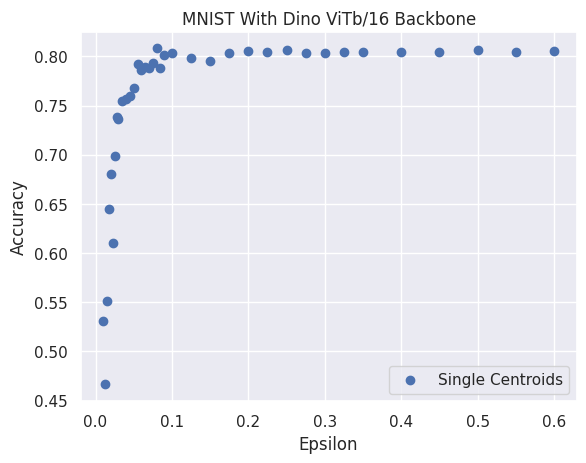

In [ ]:
eps =  [0.01, 0.0125, 0.015, 0.0175, 0.02, 0.0225, 0.025, 0.0275, 0.03, 0.035, 0.04,
        0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.1, 0.125, 0.15,
        0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]

delta = 1e-5

dp_params = dict()
dp_params['delta'] = delta
dp_params['epsilons'] = eps

# single centroids
accs_centroids = accuracy_epsilon_sweep(dp_params, data, model_type = 'dp_normalized_centroids')

# # subsampling
# q = 0.01
# reps_count = 64
# dp_mechanism_args = {'prediction_model_for_representers': 'logistic_regression',
#                      'amplification_args' : {'sampling_probability': q, 'representers_count': reps_count}}
# accs_sampled = accuracy_epsilon_sweep(dp_params, data, model_type = 'dp_normalized_centroids', dp_mechanism_args = dp_mechanism_args)

# compare subsampling with single centroids
# accs_dict = {f'Subsampling {reps_count}, {q}': accs_sampled, 'Single Centroids': accs_centroids}
accs_dict = {'Single Centroids' : accs_centroids}
dataset_name = 'MNIST'
backbone_name = 'Dino ViTb/16'
title = dataset_name + ' With ' + backbone_name + ' Backbone'


plot_dict(accs_dict, x = eps, title=title)
plt.show()

100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


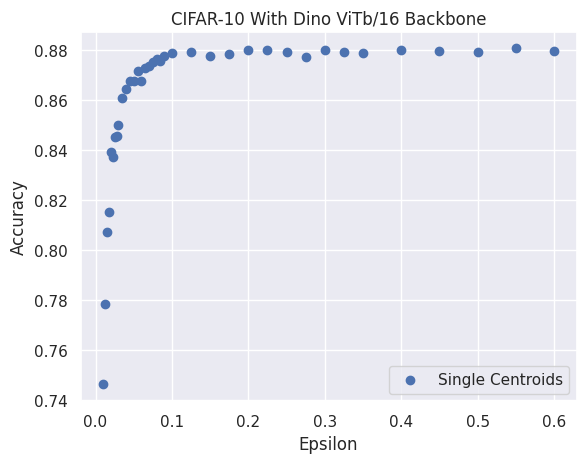

In [ ]:
eps =  [0.01, 0.0125, 0.015, 0.0175, 0.02, 0.0225, 0.025, 0.0275, 0.03, 0.035, 0.04,
        0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.1, 0.125, 0.15,
        0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]

delta = 1e-4

dp_params = dict()
dp_params['delta'] = delta
dp_params['epsilons'] = eps

# single centroids
accs_centroids = accuracy_epsilon_sweep(dp_params, data, model_type = 'dp_normalized_centroids')

# # subsampling
# q = 0.01
# reps_count = 64
# dp_mechanism_args = {'prediction_model_for_representers': 'logistic_regression',
#                      'amplification_args' : {'sampling_probability': q, 'representers_count': reps_count}}
# accs_sampled = accuracy_epsilon_sweep(dp_params, data, model_type = 'dp_normalized_centroids', dp_mechanism_args = dp_mechanism_args)

# compare subsampling with single centroids
# accs_dict = {f'Subsampling {reps_count}, {q}': accs_sampled, 'Single Centroids': accs_centroids}
accs_dict = {'Single Centroids' : accs_centroids}
dataset_name = 'CIFAR-10'
backbone_name = 'Dino ViTb/16'
title = dataset_name + ' With ' + backbone_name + ' Backbone'


plot_dict(accs_dict, x = eps, title=title)
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression as LR
lr = LR(max_iter = 100)
lr.fit(normalize(data['X_train']), data['y_train'])
print(lr.score(normalize(data['X_test']), data['y_test']))

0.9461


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.



Increase the number of iterations (max_iter) or scale the data as shown in:

    https://scikit-learn.org/stable/modules/preprocessing.html

Please also refer to the documentation for alternative solver options:

    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.linear_model import LogisticRegression as LR
lr = LR(max_iter = 100)
lr.fit(normalize(data['X_train']), data['y_train'])
print(lr.score(normalize(data['X_test']), data['y_test']))

0.9641


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## MSN

In [ ]:
# model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = 'msn_vitb16'
model_dict = ModelExperiment(model_name = model_name).get_model()
model = model_dict['model']
model.to(device)




# data
preprocessing_args = dict()
preprocessing_args['type'] = 'imagenet_resize'
preprocessing_args['resize_size'] = 224

dataloader_args = dict()
dataloader_args['batch_size'] = 32

dataset_name = 'cifar10_torch'

dataset = DatasetExperiment(name = dataset_name, preprocessing_args = preprocessing_args)
train_dataloader, test_dataloader = dataset.get_dataloaders(dataloader_args)




# feature extraction
feature_extractor = ImageFeatureExtractor_Torch(model, model_name)

# get train embeddings
print('train dataset')
X_train, y_train = feature_extractor.extract(train_dataloader, device)

# get test embeddings
print('test dataset')
X_test, y_test = feature_extractor.extract(test_dataloader, device)


## store features
data = {'X_train' : X_train, 'y_train' : y_train, 'X_test': X_test, 'y_test': y_test}
root = '/content/drive/MyDrive'
experiment_identifier = model_name + '_' + dataset_name

store_features(data, root = root, experiment_identifier=experiment_identifier)

Files already downloaded and verified

Files already downloaded and verified

train dataset

###Extracting features###


 64%|██████▍   | 1006/1563 [06:20<03:35,  2.59it/s]

## SimCSE

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = 'sup_simcse_roberta_large'
model_dict = ModelExperiment(model_name = model_name).get_model()
model = model_dict['model']
model.to(device)




## Dot Products

Sampling Per Class Dot Products


100%|██████████| 10/10 [03:13<00:00, 19.38s/it]


Sampling Intra Class Dot Products!


100%|██████████| 50000/50000 [00:00<00:00, 56130.10it/s]


Sampling Inter Class Dot Products!


100%|██████████| 50000/50000 [00:01<00:00, 33876.95it/s]


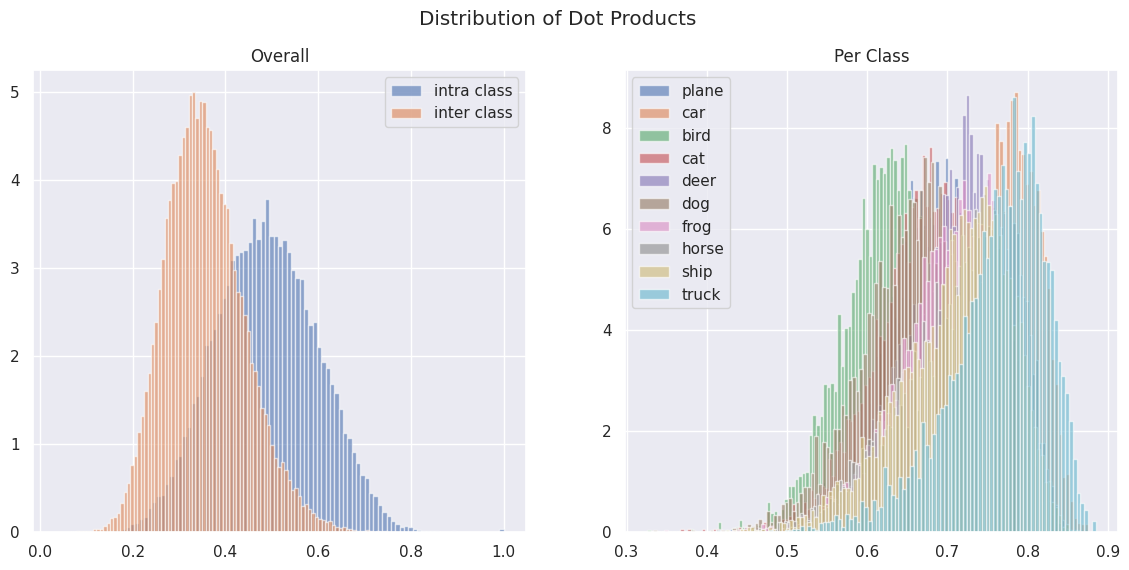

In [ ]:
X = data['X_train']
y = data['y_train']


classes = {0: 'plane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog',
           6: 'frog', 7 : 'horse', 8 : 'ship', 9 : 'truck'}

iterations_full = 50000
iterations_per_class = 200000

model_name = 'Dino ViTb/16'
dataset_name = 'CIFAR-10'
suptitle = f'Distribution of Dot Products in {model_name} Emebeddings ({dataset_name})'
histogram_args = {'bins' : 100, 'density' : True, 'alpha' : 0.6}

plot_dot_products(X, y, iterations_full = iterations_full, iterations_per_class = iterations_per_class,
                  class_names = classes, histogram_args = histogram_args, suptitle = suptitle)
plt.show()

Sampling Per Class Dot Products


100%|██████████| 10/10 [03:24<00:00, 20.44s/it]


Sampling Intra Class Dot Products!


100%|██████████| 50000/50000 [00:02<00:00, 24706.90it/s]


Sampling Inter Class Dot Products!


100%|██████████| 50000/50000 [00:02<00:00, 17877.92it/s]


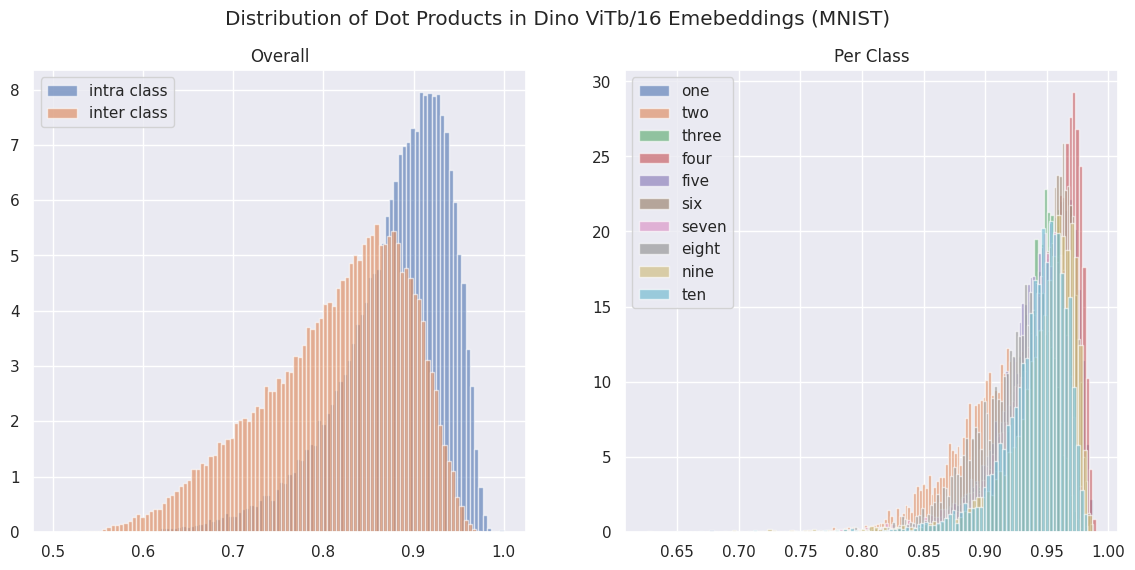

In [ ]:
X = data['X_train']
y = data['y_train']


classes = {0: 'one', 1: 'two', 2: 'three', 3: 'four', 4: 'five', 5: 'six',
           6: 'seven', 7 : 'eight', 8 : 'nine', 9 : 'ten'}

iterations_full = 50000
iterations_per_class = 200000

model_name = 'Dino ViTb/16'
dataset_name = 'MNIST'
suptitle = f'Distribution of Dot Products in {model_name} Emebeddings ({dataset_name})'
histogram_args = {'bins' : 100, 'density' : True, 'alpha' : 0.6}

plot_dot_products(X, y, iterations_full = iterations_full, iterations_per_class = iterations_per_class,
                  class_names = classes, histogram_args = histogram_args, suptitle = suptitle)
plt.show()

## Deep Centroids

### Utilities

In [17]:
# imports

!pip install opacus

In [34]:
# model

import torch.nn as nn
import torch.nn.functional as F

class CentroidClassifier(nn.Module):
    def __init__(self, embedding_size, class_number):
        super().__init__()
        self.embedding_projection = nn.Linear(embedding_size, embedding_size)
        self.classifier = nn.Linear(embedding_size, class_number, bias = False)

    def forward(self, x):
        x = self.embedding_projection(x)
        x = F.relu(x)
        x = F.normalize(x)
        x = self.classifier(x)
        return x



In [70]:
# experiment loop

def deep_centroids_experiment(data, dataloader_args, dp_params, optimizer_args):

  #data
  X_train = data['X_train']
  X_test = data['X_test']
  y_train = data['y_train']
  y_test = data['y_test']

  #normalize
  from sklearn.preprocessing import normalize
  X_train = normalize(X_train)
  X_test = normalize(X_test)

  # dataloader
  train_dataloader = get_dataloader_from_xy(X_train, y_train, dataloader_args)
  test_dataloader = get_dataloader_from_xy(X_test, y_test, dataloader_args)



  # classifier
  embedding_size = X_train.shape[1]
  class_number = len(np.unique(y_train))

  dp_classifier = DP_CentroidClassifier(**dp_params)
  dp_classifier.dp_fit(X_train, y_train)

  centroid_classifier = CentroidClassifier(embedding_size = embedding_size, class_number = class_number)


  centroid_classifier.classifier.weight = torch.nn.Parameter(
      torch.from_numpy(dp_classifier.centroids).to(torch.float32))
  centroid_classifier.classifier.weight.trainable = False

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(centroid_classifier.parameters(), **optimizer_args)

  return train_dataloader, test_dataloader, centroid_classifier, optimizer, criterion



### Results

In [73]:
# non private projection
dataloader_args = {'batch_size': 1000, 'shuffle': True}
dp_params = {'epsilon': 0.3, 'delta' : 1e-4}
optimizer_args = {'lr' : 1, 'momentum': 0.9}

train_dataloader, test_dataloader, centroid_classifier, optimizer, criterion = deep_centroids_experiment(data, dataloader_args, dp_params, optimizer_args)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

centroid_classifier.to(device)
num_epochs = 10
train_loss = training_loop(centroid_classifier, train_dataloader,
                           test_dataloader, num_epochs, optimizer, criterion, device)

Training


100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


 Accuracy on the test images: 0.9466


In [68]:
from opacus import PrivacyEngine

# data and experiment args
dataloader_args = {'batch_size': 1000, 'shuffle': True}
dp_params = {'epsilon': 0.05, 'delta' : 1e-4}
optimizer_args = {'lr' : 1, 'momentum': 0.9}

num_epochs = 10

train_dataloader, test_dataloader, centroid_classifier, optimizer, criterion = deep_centroids_experiment(
    data, dataloader_args, dp_params, optimizer_args)


# dp
privacy_engine = PrivacyEngine()

dp_params = {'epsilon': 0.05, 'delta' : 1e-4}
centroid_classifier, optimizer, train_dataloader = privacy_engine.make_private_with_epsilon(
    module=centroid_classifier,
    optimizer=optimizer,
    data_loader=train_dataloader,
    epochs=num_epochs,
    target_epsilon=dp_params['epsilon'],
    target_delta=dp_params['delta'],
    max_grad_norm=1,
)

# train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
centroid_classifier.to(device)

train_loss = training_loop(centroid_classifier, train_dataloader,
                           test_dataloader, num_epochs, optimizer, criterion, device)

/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


Training


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 10/10 [00:30<00:00,  3.09s/it]


 Accuracy on the test images: 0.6655
